<a href="https://colab.research.google.com/github/MyriadSpace/Concepts_and_Apps_of_Deep_Learning/blob/main/CNN/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 파이토치를 이용한 MNIST CNN 분류모델
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## 하이퍼파라메터 설정
batch_size = 64
test_batch_size = 1000
epochs = 50
lr = 0.001
momentum = 0.01
gpu_use = True
log_interval = 200

## GPU가 설치되어있고 사용예정이라면 True
cuda_use = gpu_use and torch.cuda.is_available()
device = torch.device("cuda" if cuda_use else "cpu")
print(cuda_use)
print("set hyperparameters done")

True
set hyperparameters done


In [ ]:
## 모든 데이터 자료구조를 tensor로 변환
transform = transforms.Compose([transforms.ToTensor()]) 

## torch.utils.data 리스트에 저장된 URL을 통해 MNIST 데이터 입력
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, 
                 transform=transform), 
    batch_size = batch_size, shuffle=True) #, **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                 transform=transform), 
    batch_size=test_batch_size, shuffle=True) #, **kwargs)

print('data loading done')

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!
data loading done


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
## 모델 설계하기

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
## Net으로 정의된 CNN 학습 모델을 model로 객체화
## 모델이 실행될 GPU 또는 CPU에 할당
model = Net().to(device)

##  최적화 라이브러이 RMSprop 선정
optimizer = optim.RMSprop(model.parameters(), lr=lr) #, momentum=momentum)

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
## CNN 모델 학습 루틴 정의
## 목적함수 := NLL (negative log likelihood) --> cross entropy와 같은 목적함수임
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## CNN 모델 검증 루틴 정의
def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
## CNN 모델 학습시키기
for epoch in range(1, epochs):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(log_interval, model, device, test_loader)

torch.save(model, './model.pt')

print('train is done')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304114
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.186772
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.137578
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.063620
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.114020

Test set: Average loss: 0.0736, Accuracy: 9753/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.025653
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.128829
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.030022
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024077
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.067723

Test set: Average loss: 0.0376, Accuracy: 9873/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.046961
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.002839
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.010708
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.048954
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.002978

Test set: Average loss: 0.0455, Accuracy: 9855/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.005829
Train Epoch: 4 [12800/60000 (21%)]	Lo

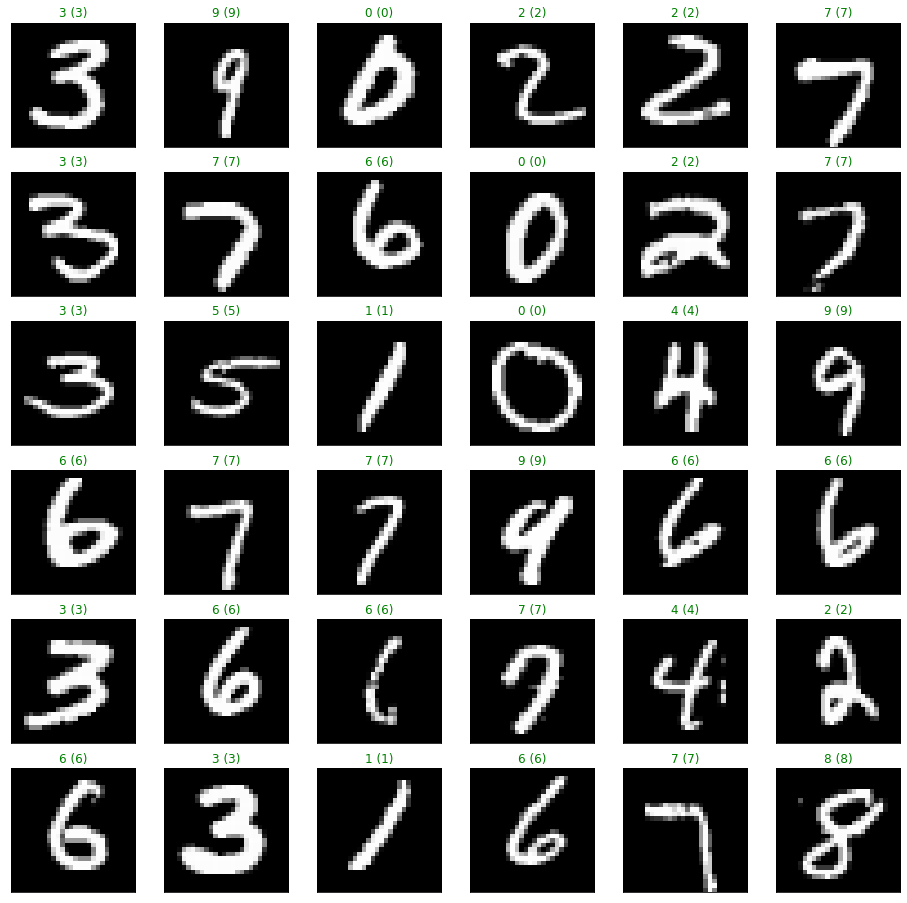

In [ ]:

# Test  데이터셋에서 배치크기만큼 이미지 추출
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 학습된 CNN 모델을 통해 예측값 출력
images = images.to(device)
output = model(images)

# 10개 성분을 가지는 예측값 벡터에서 최대 확률을 가지는 인덱스를 예측값으로 변환
_, preds = torch.max(output, 1)

# 이미지 plot을 위해 텐서에서 numpy 자료구조로 변환
images = images.to(torch.device("cpu"))
images = images.numpy()

# 이미지 plot: 레이블과 예측값이 다르면 적색으로 표시 ()안이 레이블
fig = plt.figure(figsize=(16, 16))
for idx in np.arange(36):
    ax = fig.add_subplot(6, 6, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))